In [54]:
%matplotlib inline
# jt -t oceans16 -f fira -fs 10 -cellw 1200 -T -N -cursc r
import aipy, uvtools
import numpy as np
import pylab as plt
import random
import math
import os.path
import h5py
from jupyterthemes import jtplot
jtplot.style(theme='chesterish')
import pandas as pd
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

from tensorflow.keras.layers.experimental import preprocessing

from hera_sim import foregrounds, noise, sigchain, rfi, simulate
from sklearn.preprocessing import MinMaxScaler, StandardScaler

2.4.0


# Experimentation
### RFI Mask
This is a boolean mask: `True` = RFI, `False` = no RFI

Parameters:
- 6 hours in JD, 1500 units
  - times match: using range π/2 for lsts in vis plot, with 1500 snapshots
- 1024 channels, 100-200 MHz

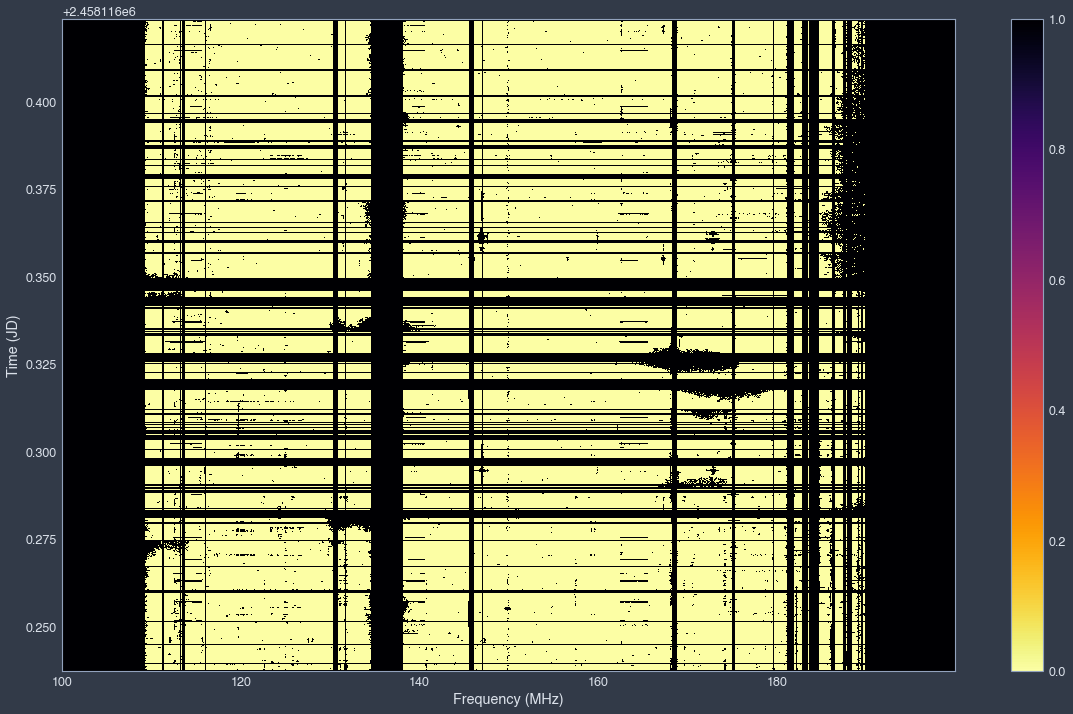

(1500, 1024)


In [73]:
f = h5py.File("mask_HERA.hdf5", "r")
plt.figure(figsize=(20,12))
mask = f['mask']
plt.imshow((mask[()]), cmap='inferno_r', aspect='auto',
           origin='lower', vmin=0, vmax=1,
           extent=(f['axes']['frequency'][0]/1e6,f['axes']['frequency'][-1]/1e6,
                  f['axes']['time'][0], f['axes']['time'][-1]))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time (JD)')
plt.grid()
plt.colorbar()
plt.show()
print(mask.shape)
# print(mask[()])

num_jd = mask.shape[0]
num_freq_channels = mask.shape[1]

### Generate custom masks

Take horizontal or vertical pixel slice of the mask. Spans of the `True` sections = spans of RFI

In [93]:
'''
Get RFI spans from one row/col
'''
def get_RFI_spans(row, isRow=False):
    spans = [(key, sum(1 for _ in group)) for key, group in itertools.groupby(row)]
#     spans = spans[1:-1] # remove first and last element of mask?
    if len(spans) == 1:
        raise Exception("Error: all values in the row/col are True; select another one")
    if isRow:
        start = spans[0][1]
        end = spans[-1][1]
        print("RFI bookends", start, end)
        spans = spans[1:-1]
        return spans, start, end
    else:
        return spans

rfi_widths, start_mask, end_mask = get_RFI_spans(mask[1434], isRow=True)
rfi_heights = get_RFI_spans(mask[:,166])

print("RFI widths", rfi_widths)
# print("RFI heights", rfi_heights)

RFI bookends 95 111
RFI widths [(False, 20), (True, 2), (False, 15), (True, 1), (False, 2), (True, 1), (False, 1), (True, 4), (False, 10), (True, 1), (False, 12), (True, 1), (False, 3), (True, 1), (False, 6), (True, 1), (False, 6), (True, 1), (False, 126), (True, 1), (False, 1), (True, 5), (False, 9), (True, 1), (False, 14), (True, 1), (False, 12), (True, 38), (False, 76), (True, 5), (False, 9), (True, 2), (False, 27), (True, 2), (False, 187), (True, 6), (False, 12), (True, 1), (False, 50), (True, 4), (False, 43), (True, 1), (False, 14), (True, 2), (False, 1), (True, 6), (False, 9), (True, 7), (False, 2), (True, 11), (False, 15), (True, 4), (False, 8), (True, 4), (False, 1), (True, 12), (False, 1)]


Generate randomized mask from spans

In [57]:
def plot_mask(mask, mask2, mask3):
    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.grid(False)
    plt.imshow(mask, cmap='inferno_r') # black is RFI
    plt.subplot(1, 3, 2)
    plt.grid(False)
    plt.imshow(mask2, cmap='inferno_r')
    plt.subplot(1, 3, 3)
    plt.grid(False)
    plt.imshow(mask3, cmap='inferno_r')

'''
Generate random RFI mask with dimensions time x freq, given RFI spans from a real mask
'''
def generate_one_mask(time, freq, widths, heights, plot=False):
    random.shuffle(widths)
    random.shuffle(heights)
    
    # row by row
    one_row = []
    for w in widths:
        one_row.extend([w[0]] * w[1])
    mask = np.tile(one_row, (time, 1)) # copy one_row `time` times in the vertical direction
#     print(mask.shape)
#     print(widths)
    
    # col by col
    one_col = []
    for w in heights:
        one_col.extend([w[0]] * w[1])
    mask2 = np.tile(np.array(one_col).reshape((time, 1)), (1, freq))
#     print(mask2.shape)
    
    combined_mask = np.logical_or(mask, mask2) # any cell with True will have RFI
    if plot:
        plot_mask(mask, mask2, combined_mask)
    return combined_mask

'''
Generate n masks
'''
def generate_masks(n, time, freq, widths, heights):
    res = []
    for i in range(n):
        res.append(generate_one_mask(time, freq, widths, heights))
    return np.array(res)


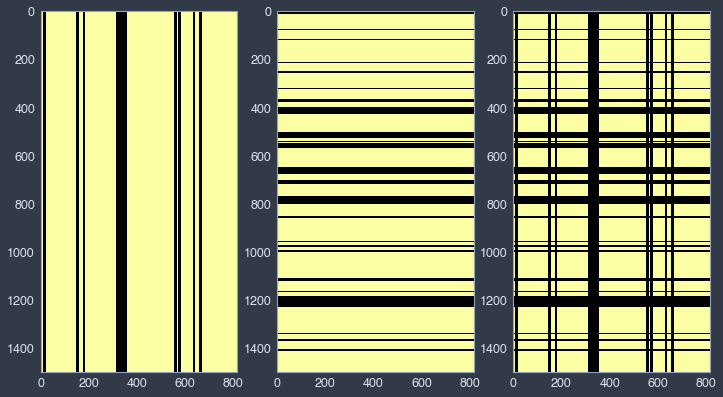

In [74]:
custom_mask = generate_one_mask(num_jd, num_freq_channels-(start_mask+end_mask), rfi_widths, rfi_heights, plot=True)
# print(custom_mask)

### Visibility waterfall plot

In [64]:
# sigchain.gen_gains?

In [103]:
'''
Generate one visibility
'''
def generate_one_vis(lsts, fqs, bl_len_ns):
    # point-source and diffuse foregrounds
    Tsky_mdl = noise.HERA_Tsky_mdl['xx']
    vis = foregrounds.diffuse_foreground(lsts, fqs, bl_len_ns, Tsky_mdl)
    vis += foregrounds.pntsrc_foreground(lsts, fqs, bl_len_ns, nsrcs=200)

    # noise
    tsky = noise.resample_Tsky(fqs,lsts,Tsky_mdl=noise.HERA_Tsky_mdl['xx'])
    t_rx = 150.
#     OMEGA_P = (0.72)*np.ones(1024) # from before; fraction of sky telescope is looking at; normalizes noise
    OMEGA_P = noise.bm_poly_to_omega_p(fqs) # default; from the hera_sim docs
    nos_jy = noise.sky_noise_jy(tsky + t_rx, fqs, lsts, OMEGA_P)
    vis += nos_jy
    
    # crosstalk, gains
    xtalk = sigchain.gen_whitenoise_xtalk(fqs)
#     g = sigchain.gen_gains(fqs, [1,2,3,4], 0) # default 0.1 # leave out for now
    vis = sigchain.apply_xtalk(vis, xtalk)
#     vis = sigchain.apply_gains(vis, g, (1,2))

    return vis[:, :, np.newaxis]

'''
Plot one visibility
MX is max value of color scale in the plot
DRNG = MX - min value of color scale in the plot
'''
def plot_one_vis(vis, ylim, MX, DRNG, figsize):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    fig.sca(ax1)
    uvtools.plot.waterfall(vis, mode='log', mx=MX, drng=DRNG)
    plt.grid(False)  
    plt.colorbar(label=r"Amplitude [log$_{10}$(V/Jy)]")
    plt.ylim(0,ylim)

    fig.sca(ax2)
    uvtools.plot.waterfall(vis, mode='phs')
    plt.grid(False)
    plt.colorbar(label="Phase [rad]")
    plt.ylim(0,ylim)
    plt.xlabel("Frequency channel")

    fig.text(0.02, 0.5, 'LST [rad]', ha='center', va='center', rotation='vertical')

'''
Generate n visibilities
'''
def generate_vis(n, lsts, fqs, bl_len_ns):
    res = []
    for i in range(n):
        res.append(generate_one_vis(lsts, fqs, bl_len_ns))
    return np.array(res)

Calculate start freq, end freq, and # channels

In [104]:
# Original range: 100 - 200 GHz, 1024 channels
start_freq = (100 + 100*start_mask/num_freq_channels) / 1000

end_freq = (200 - 100*end_mask/num_freq_channels) / 1000
num_reduced_channels = num_freq_channels - start_mask - end_mask
print(start_freq, end_freq, num_reduced_channels)

0.10927734375 0.18916015625 818


In [105]:
foregrounds.diffuse_foreground?

(1500, 818, 1)


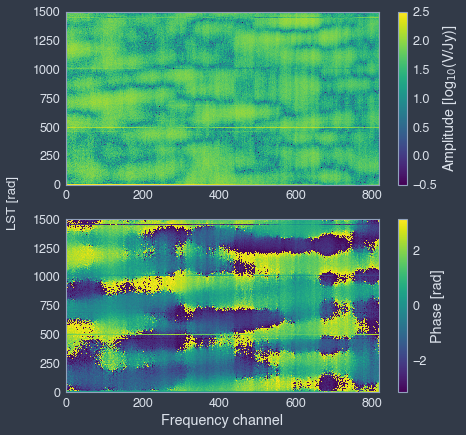

In [106]:
lsts = np.linspace(0, 0.5*np.pi, 1500, endpoint=False) # local sidereal times; start range, stop range, number of snapshots
# 1500 to match the mask; π/2 ~ 6h
fqs = np.linspace(start_freq, end_freq, 1024, endpoint=False) # frequencies in GHz; start freq, end freq, number of channels
################### why does this require 1024 channels to get 818 channels??
# fqs = np.linspace(.1, .2, 1024, endpoint=False) # original
bl_len_ns = np.array([30.,0,0]) # ENU coordinates

vis = generate_one_vis(lsts, fqs, bl_len_ns)
vis = vis[:, start_mask:(vis.shape[1]-end_mask)] # to account for start and end mask
print(vis.shape)
plot_one_vis(vis[:,:,0], 1500, 2.5, 3, (7,7))

# plt.imshow(np.log(np.abs(vis[:,:,0])))

### Apply mask to visibility

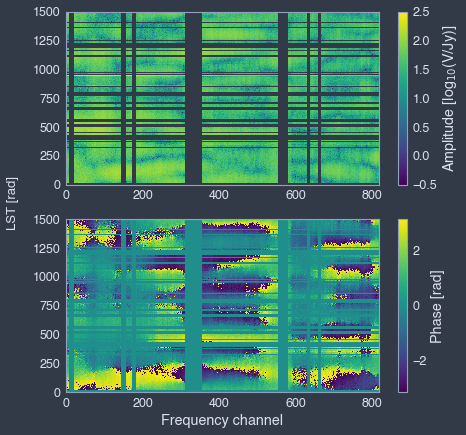

In [95]:
vis[custom_mask == True] = 0
plot_one_vis(vis[:,:,0], 1500, 2.5, 3, (7,7))

# Create dataset

Create visibilities and masks

In [ ]:
lsts = np.linspace(0, 0.5*np.pi, 1500, endpoint=False) # local sidereal times; start range, stop range, number of snapshots
# 1500 to match the mask; π/2 ~ 6h
fqs = np.linspace(start_freq, end_freq, num_reduced_channels, endpoint=False) # frequencies in GHz; start freq, end freq, number of channels
bl_len_ns = np.array([30.,0,0]) # ENU coordinates

vis = generate_vis(10, lsts, fqs, bl_len_ns)
mask = generate_one_mask(1500, 1024-(start_mask+end_mask), rfi_widths, rfi_heights)

Create data and labels

In [101]:
data = vis.copy()
for i, v in enumerate(data):
    v[mask == True] = 0

# print(np.count_nonzero(train_dataset[0]==0)) # check number of 0's in a given vis (to check if mask worked)

labels = vis

In [ ]:
data = np.load("dataset.npy")
labels = np.load("labels.npy")
print(data.shape, labels.shape)

In [ ]:
np.save("dataset.npy", data)
np.save("labels.npy", labels)

Separate train and test sets

In [102]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6, 1500, 818, 1) (4, 1500, 818, 1) (6, 1500, 818, 1) (4, 1500, 818, 1)


# ML model

In [228]:
def build_and_compile_model():
  model = keras.Sequential([
#       layers.Dense(1024, activation='relu', input_shape=(1500, 1024)),
      layers.Conv2D(64, kernel_size=3, activation='relu', padding='same', input_shape=(1500,1024,1)),
      layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
      layers.Dense(1)
  ])

  model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['mae','acc'])
  return model

In [230]:
model = build_and_compile_model()
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 1500, 1024, 64)    128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1500, 1024, 32)    2080      
_________________________________________________________________
dense_39 (Dense)             (None, 1500, 1024, 1)     33        
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


In [231]:
%%time
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=1, epochs=5)

Epoch 1/5
1/1 [==============================] - 19s 19s/step - loss: 0.0234 - mae: 0.0234 - acc: 0.0000e+00 - val_loss: 0.0193 - val_mae: 0.0193 - val_acc: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 17s 17s/step - loss: 0.0210 - mae: 0.0210 - acc: 0.0000e+00 - val_loss: 0.0183 - val_mae: 0.0183 - val_acc: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 14s 14s/step - loss: 0.0200 - mae: 0.0200 - acc: 0.0000e+00 - val_loss: 0.0167 - val_mae: 0.0167 - val_acc: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 18s 18s/step - loss: 0.0183 - mae: 0.0183 - acc: 0.0000e+00 - val_loss: 0.0163 - val_mae: 0.0163 - val_acc: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 15s 15s/step - loss: 0.0178 - mae: 0.0178 - acc: 0.0000e+00 - val_loss: 0.0151 - val_mae: 0.0151 - val_acc: 0.0000e+00
CPU times: user 59.6 s, sys: 1min 6s, total: 2min 5s
Wall time: 1min 22s


In [232]:
preds = model.predict(X_train)
preds

array([[[[0.00190838],
         [0.00190838],
         [0.00190838],
         ...,
         [0.00190838],
         [0.00190838],
         [0.00190838]],

        [[0.00190838],
         [0.00190838],
         [0.00190838],
         ...,
         [0.00190838],
         [0.00190838],
         [0.00190838]],

        [[0.00190838],
         [0.00190838],
         [0.00190838],
         ...,
         [0.00190838],
         [0.00190838],
         [0.00190838]],

        ...,

        [[0.00190838],
         [0.00190838],
         [0.00190838],
         ...,
         [0.00190838],
         [0.00190838],
         [0.00190838]],

        [[0.00190838],
         [0.00190838],
         [0.00190838],
         ...,
         [0.00190838],
         [0.00190838],
         [0.00190838]],

        [[0.00190838],
         [0.00190838],
         [0.00190838],
         ...,
         [0.00190838],
         [0.00190838],
         [0.00190838]]],


       [[[0.00190838],
         [0.00190838],
         [0.00

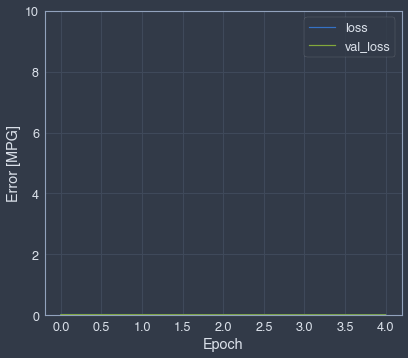

In [233]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
f.close()